In [11]:
#必要なライブラリのインポート
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [2]:
#ディレクトリの移動（発現データなどがあるフォルダに移動）
os.chdir("C:/Users/Owner/Desktop/...")

In [5]:
#遺伝子発現データの圧縮　まずはクラスター毎にまとめた遺伝子発現のcsvファイルを読み込む
cluster_data_file = open("GSE13576_cluster1_data.csv", 'r')   #例としてクラスター１のデータを読み込む
cluster_data_list = cluster_data_file.readlines()
cluster_data_file.close()

n_sample = len(cluster_data_list)    #サンプル数を取得

n_gene = 15    #遺伝子数を取得（予め分かってものとする）

input_data = []

for i in range(n_sample):
    input_data += cluster_data_list[i].split(',')

#オートエンコーダーに読み込ませるように整形
input_data = np.asfarray(input_data)
input_data = input_data.reshape(n_sample, n_gene)

In [7]:
#オートエンコーダーの実装

class Autoencoder_sig:
    def __init__(self, vis_dim, W, b):   #パラメータの初期値設定
        self.W = W
        self.b = b
        self.h_W = np.zeros(self.W.shape) + 1e-8
        self.h_b = np.zeros(self.b.shape) + 1e-8
        self.a = np.zeros(vis_dim).astype('float64')
        self.h_a = np.zeros(self.a.shape) + 1e-8
        self.params = [self.W, self.b]
        
    def encode(self, x):   #圧縮部分
        u = np.dot(x, self.W) + self.b
        return np.where(u <= 0, 0, u)
    
    def decode(self, x):   #復元部分
        u = np.dot(x, self.W.T) + self.a
        return 1. / (1 + np.exp(-u))
    
    def reconst_error(self, t, y):    #誤差を計算
        return -np.sum(t * np.log(y) + (1.0-t) * np.log(1.0-y), axis=1)
        
    def train(self, x, eta=np.float32(0.1)):   #トレーニング
        #順伝播
        noise = np.random.binomial(size=x.shape, n=1, p=0.7)
        tilde_x = x * noise
        self.z = self.encode(tilde_x)
        reconst_x = self.decode(self.z)
        
        error = self.reconst_error(x, reconst_x)
        
        #逆伝播
        delta_2 = reconst_x - x
        delta_1 = np.dot(delta_2, self.W)  * np.where(self.z <= 0, 0, 1)
        
        #勾配導出
        da = np.dot(np.ones(len(reconst_x)), delta_2)
        db = np.dot(np.ones(len(self.z)), delta_1)
        dW = np.dot(tilde_x.T, delta_1) + np.dot(self.z.T, delta_2).T
        
        #パラメータ更新（手法はAdaGrad）
        self.h_W += dW * dW
        self.W -= eta / np.sqrt(self.h_W) * dW
        
        self.h_b += db * db
        self.b -= eta / np.sqrt(self.h_b) * db
        
        self.h_a += da * da
        self.a -= eta / np.sqrt(self.h_a) * da
        
        return error, reconst_x

EPOCH:0, ERROR:10.295622
EPOCH:200, ERROR:9.401264
EPOCH:400, ERROR:9.399952
EPOCH:600, ERROR:9.388072
EPOCH:800, ERROR:9.373625
EPOCH:1000, ERROR:8.992950


Ttest_indResult(statistic=2.0312877645260548, pvalue=0.04714148047861252)

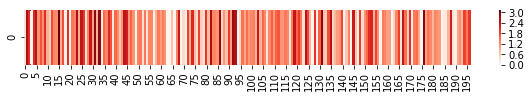

In [16]:
#データを与えて圧縮させる

X = input_data

in_dim = X.shape[1]  #入力次元数
out_dim = 1   #圧縮次元数

W = np.random.randn(in_dim, out_dim).astype('float64') * np.sqrt(2.0 / out_dim)
b = np.zeros([out_dim]).astype('float64')


n_epochs = 1001
batch_size = 10
n_batches = X.shape[0] // batch_size

AE = Autoencoder_sig(in_dim, W, b)        
    
for epoch in range(n_epochs):
    np.random.shuffle(X)
    err_all = []
    
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        
        err, reconst = AE.train(X[start:end, :])
        err_all.append(err)
        
    if epoch % 200 == 0:
        print('EPOCH:%d, ERROR:%lf' % (epoch, np.mean(err_all)))
        
#再発した患者としなかった患者で差のある値になっているか、ヒートマップとt検定で確認（ランダム性あり）
err, reconst = AE.train(X)
plt.figure(figsize=(10, 1))
sns.heatmap(AE.z.T, cmap='Reds')
stats.ttest_ind(AE.z.T[0, 0:40], AE.z.T[0, 40:197], equal_var=False)

In [17]:
#圧縮した値をtxtファイルに保存
np.savetxt("GSE13576_cluster1_value_data.txt", AE.z, delimiter=",")

In [20]:
#圧縮したクラスター値20個分をまとめたcsvファイルを読み込む
clusters_data_file = open("GSE13576_20cluster_node_data.csv", 'r')
clusters_data_list = clusters_data_file.readlines()
clusters_data_file.close()

n_sample = len(clusters_data_list)

n_cluster = 20   #クラスター数

clusters_data = []

for i in range(n_sample):
    clusters_data += clusters_data_list[i].split(',')

clusters_data = np.asfarray(clusters_data)
clusters_data = clusters_data.reshape(n_sample, n_cluster+2)

In [21]:
#入力部分と正解ラベルに分割
input_data = clusters_data[:, :n_cluster]
correct_data = clusters_data[:, n_cluster:]

#テストデータと訓練データに分割
x_train = input_data[:130, :]
t_train = correct_data[:130, :]
        
x_test = input_data[130:, :]
t_test = correct_data[130:, :]

In [24]:
#ディープラーニングの実装

n_train = x_train.shape[0] # 訓練データのサンプル数
n_test = x_test.shape[0]   # テストデータのサンプル数

# -- 各設定値 --
n_in = n_cluster  # 入力層のニューロン数
n_mid1 = 20  # 1つ目の中間層のニューロン数
n_mid2 = 5  # 2つ目の中間層のニューロン数
n_out = 2  # 出力層のニューロン数


wb_width = 0.5  # 重みとバイアスの広がり具合
eta = 0.01  # 学習係数
epoch = 1000
batch_size = 10
interval = 100  # 経過の表示間隔
dr1 = 0.3   #中間層１のドロップアウト率
dr2 = 0.3   #中間層2のドロップアウト率


# -- 各層の継承元 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2.0 / n)# 重み（行列）
        self.b = np.random.randn(n) * np.sqrt(2.0 / n)  # バイアス（ベクトル）

        self.h_w = np.zeros(( n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):      
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

# -- 中間層 --
class MiddleLayer_1(BaseLayer):
    def forward(self, x):
        self.x = x
        
        
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)  # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)  # ReLUの微分

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        
class MiddleLayer_2(BaseLayer):
    def forward(self, x):
        self.x = x
        
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)  # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)  # ReLUの微分

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)

# -- 出力層 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)  # ソフトマックス関数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio  # ニューロンを無効にする確率

    def forward(self, x, is_train):  # is_train: 学習時はTrue
        if is_train:
            rand = np.random.rand(*x.shape)  # 入力と同じ形状の乱数の行列
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)  # 1:有効 0:無効
            self.y = x * self.dropout  # ニューロンをランダムに無効化
        else:
            self.y = (1-self.dropout_ratio)*x  # テスト時は出力を下げる
        
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout  # 無効なニューロンでは逆伝播しない



# -- 順伝播 --
def forward_propagation(x, is_train):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    output_layer.forward(dropout_1.y)

# -- 順伝播（2層用） --
def forward_propagation_2(x, is_train):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout_2.y)

# -- 逆伝播 --
def backpropagation(t):
    output_layer.backward(t)
    dropout_1.backward(output_layer.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)    

# -- 逆伝播（2層用） --
def backpropagation_2(t):
    output_layer.backward(t)
    dropout_2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)
    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)

# -- 重みとバイアスの更新 --
def uppdate_wb():
    middle_layer_1.update(eta)
    output_layer.update(eta)
    
# -- 重みとバイアスの更新（2層用） --
def uppdate_wb_2():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

# -- 誤差を計算 --
def get_error(t, batch_size):
    return -np.sum(t*np.log(output_layer.y) + (1.0-t)*np.log(1.0-output_layer.y)) / batch_size  # 交差エントロピー誤差

Epoch:0/1000 Error_train:7.443296903345868 Error_test:4.845366846272258
Epoch:100/1000 Error_train:0.9535794662614703 Error_test:1.1400629066855634
Epoch:200/1000 Error_train:0.7655561730779936 Error_test:1.0103841191167222
Epoch:300/1000 Error_train:0.6783204726298857 Error_test:0.9231949736375674
Epoch:400/1000 Error_train:0.6238726386541241 Error_test:0.882479257012966
Epoch:500/1000 Error_train:0.5898333255455934 Error_test:0.870933252608949
Epoch:600/1000 Error_train:0.5604498259024063 Error_test:0.8603786333811564
Epoch:700/1000 Error_train:0.536201932207876 Error_test:0.8497046960981776
Epoch:800/1000 Error_train:0.5230928545905086 Error_test:0.8481243360011073
Epoch:900/1000 Error_train:0.5061347114340106 Error_test:0.849433884997366


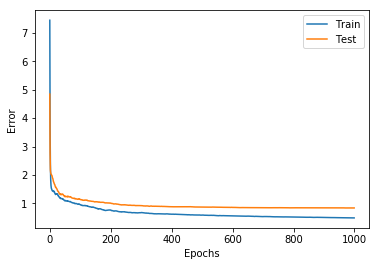

再発患者を正しく識別できた割合
Accuracy Train: 70.0% Accuracy Test: 40.0%


In [46]:
#学習部分　今回は２層ネットワークで学習

# -- 各層の初期化 --
middle_layer_1 = MiddleLayer_1(n_in, n_mid1)
dropout_1 = Dropout(dr1)
middle_layer_2 = MiddleLayer_1(n_mid1, n_mid2)
dropout_2 = Dropout(dr2)
output_layer = OutputLayer(n_mid2, n_out)

# -- 誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 学習と経過の記録 --
n_batch = n_train // batch_size  # 1エポックあたりのバッチ数

for i in range(epoch):

    # -- 誤差の計測 --  
    forward_propagation_2(x_train, False)
    error_train = get_error(t_train, n_train)
    forward_propagation_2(x_test, False)
    error_test = get_error(t_test, n_test)
    
    # -- 誤差の記録 -- 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    
    # -- 経過の表示 -- 
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))
        
    index_random = np.arange(n_train)

    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = x_train[mb_index, :]
        t = t_train[mb_index, :]
        
        # 順伝播と逆伝播
        forward_propagation_2(x, True)
        backpropagation_2(t)
        
        # 重みとバイアスの更新
        uppdate_wb_2()

        
# -- 誤差の記録をグラフ表示 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 -- 
forward_propagation_2(x_train, False)
count_train = np.sum(np.argmax(output_layer.y[:30, :], axis=1) == np.argmax(t_train[:30, :], axis=1))

forward_propagation_2(x_test, False)
count_test = np.sum(np.argmax(output_layer.y[:10, :], axis=1) == np.argmax(t_test[:10, :], axis=1))

print("再発患者を正しく識別できた割合")

print("Accuracy Train:", str(count_train/30*100) + "%",
      "Accuracy Test:", str(count_test/10*100) + "%")

In [49]:
#学習を複数回繰り返し、識別に有意に働いていた中間層１のニューロンに高い重みを持っていたクラスターをカウント

total_weight_count = np.zeros((middle_layer_1.w.shape[0], 1))

for iter in range(500):   #学習を500回繰り返す
    
    middle_layer_1 = MiddleLayer_1(n_in, n_mid1)
    dropout_1 = Dropout(dr1)
    middle_layer_2 = MiddleLayer_1(n_mid1, n_mid2)
    dropout_2 = Dropout(dr2)
    output_layer = OutputLayer(n_mid2, n_out)

    for i in range(epoch):

        # -- 学習 -- 
        index_random = np.arange(n_train)
        np.random.shuffle(index_random)  # インデックスをシャッフルする
        for j in range(n_batch):
        
            # ミニバッチを取り出す
            mb_index = index_random[j*batch_size : (j+1)*batch_size]
            x = x_train[mb_index, :]
            t = t_train[mb_index, :]
        
            # 順伝播と逆伝播
            forward_propagation_2(x, True)
            backpropagation_2(t)
        
            # 重みとバイアスの更新
            uppdate_wb_2()
            
    forward_propagation_2(input_data, False)
    
    df = middle_layer_1.y
    df = df.T

    for i in range(df.shape[0]):
        a = stats.ttest_ind(df[i, 0:30], df[i, 30:130], equal_var = False)  #中間層１のニューロンが再発の有無で有意な値をとっていたかt検定
        
        if a.pvalue < 0.05:   #P値が0.05以下なら、そのニューロンに高い重みを持っていたクラスターをカウント
            for j in range(middle_layer_1.w.shape[0]):
                
                if np.abs(middle_layer_1.w[j, i]) > 0.5:   #重みが0.5以上ならカウント
                    total_weight_count[j, :] += 1
        
    if iter % 100 == 0:
        print("繰り返し数：" + str(iter))
    
print("カウント終了")

繰り返し数：0
繰り返し数：100
繰り返し数：200
繰り返し数：300
繰り返し数：400
カウント終了


<BarContainer object of 20 artists>

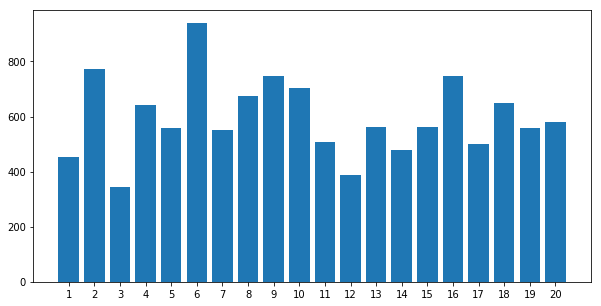

In [50]:
plt.figure(figsize=(10, 5))
height = total_weight_count.reshape(20)
label = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]
left = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.bar(left, height, tick_label=label, align="center")